In [1]:
import warnings
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D,Dropout, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,AveragePooling2D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils, to_categorical
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/vnect/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/vne

In [2]:
# load dataset list

train_data = pd.read_csv("train_vision.csv")
train_filename = train_data["filename"].values.tolist()
train_data["label"] = train_data["label"] -1
train_label = train_data["label"].values.tolist()

test_data = pd.read_csv("test_vision.csv")
test_filename = test_data["filename"].values.tolist()

print(len(train_filename), len(train_label), len(test_filename))

5850 5850 2000


In [3]:
# load train data
input_height , input_width = 128, 128
n_class = 6

def getImageArr(img_name):
        img = cv2.imread("faces_images/" + img_name, 1)
        img = np.float32(img) / 127.5 - 1   #0~255 를 평균 0이게 수정
        return img

X = []
for name in train_filename:
    X.append(getImageArr(name))
    
X, Y = np.array(X), to_categorical(np.array(train_label),n_class)
print(X.shape, Y.shape)

(5850, 128, 128, 3) (5850, 6)


In [4]:
# split dataset

train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
# X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4972, 128, 128, 3) (4972, 6)
(878, 128, 128, 3) (878, 6)


In [5]:
# load test data

real_test = []
for name in test_filename:
    real_test.append(getImageArr(name))
    
real_test = np.array(real_test)
print(real_test.shape)

(2000, 128, 128, 3)


In [6]:
 def nn_base(nClasses, input_height=128, input_width=128):
        
    img_input = Input(shape=(input_height,input_width, 3))
        
    IMAGE_ORDERING =  "channels_last"
    
    x = Conv2D(filters=16, kernel_size=(7, 7), padding='same', name='image_array', data_format=IMAGE_ORDERING)(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(7, 7), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2, 2), padding='same', data_format=IMAGE_ORDERING)(x)
    x = Dropout(.5)(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=nClasses, kernel_size=(3, 3), padding='same', data_format=IMAGE_ORDERING)(x)
    x = GlobalAveragePooling2D(data_format=IMAGE_ORDERING)(x)
    x = Activation('softmax', name='predictions')(x)
    
    model = Model(img_input, x)
    
    return model

In [7]:
model = nn_base(nClasses  = n_class,  
             input_height = 128, 
             input_width  = 128)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
image_array (Conv2D)         (None, 128, 128, 16)      2368      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      12560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 16)        0         
__________

In [36]:
with K.tf.device('/gpu:1'):
    adam = optimizers.Adam(lr=1E-2, decay=5**(-4))
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=20)

Train on 4972 samples, validate on 878 samples
Epoch 1/20
4972/4972 [==============================] - 9s 2ms/step - loss: 0.3297 - acc: 0.8797 - val_loss: 0.3867 - val_acc: 0.8724
Epoch 2/20
4972/4972 [==============================] - 7s 1ms/step - loss: 0.3164 - acc: 0.8896 - val_loss: 0.3237 - val_acc: 0.8929
Epoch 3/20
4972/4972 [==============================] - 7s 1ms/step - loss: 0.3215 - acc: 0.8831 - val_loss: 0.3390 - val_acc: 0.8895
Epoch 4/20
4972/4972 [==============================] - 7s 1ms/step - loss: 0.3125 - acc: 0.8864 - val_loss: 0.3676 - val_acc: 0.8736
Epoch 5/20
4972/4972 [==============================] - 7s 1ms/step - loss: 0.3167 - acc: 0.8880 - val_loss: 0.3665 - val_acc: 0.8770
Epoch 6/20
4972/4972 [==============================] - 7s 1ms/step - loss: 0.3117 - acc: 0.8872 - val_loss: 0.3622 - val_acc: 0.8838
Epoch 7/20
4972/4972 [==============================] - 7s 1ms/step - loss: 0.3245 - acc: 0.8803 - val_loss: 0.4431 - val_acc: 0.8508
Epoch 8/20
4972

In [19]:
with K.tf.device('/gpu:1'):
    sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    hist1 = model.fit(X_train,y_train,
                      validation_data=(X_test,y_test),
                      batch_size=32,epochs=30)

Train on 4972 samples, validate on 878 samples
Epoch 1/30
4972/4972 [==============================] - 9s 2ms/step - loss: 0.2821 - acc: 0.8966 - val_loss: 0.4440 - val_acc: 0.8702
Epoch 2/30
4972/4972 [==============================] - 7s 1ms/step - loss: 0.2657 - acc: 0.9065 - val_loss: 0.4161 - val_acc: 0.8781
Epoch 3/30
4972/4972 [==============================] - 7s 1ms/step - loss: 0.2573 - acc: 0.9083 - val_loss: 0.3642 - val_acc: 0.8850
Epoch 4/30
4972/4972 [==============================] - 7s 1ms/step - loss: 0.2491 - acc: 0.9109 - val_loss: 0.3719 - val_acc: 0.8838
Epoch 5/30
4972/4972 [==============================] - 7s 1ms/step - loss: 0.2314 - acc: 0.9143 - val_loss: 0.3213 - val_acc: 0.8975
Epoch 6/30
4972/4972 [==============================] - 7s 1ms/step - loss: 0.2337 - acc: 0.9193 - val_loss: 0.3330 - val_acc: 0.9021
Epoch 7/30
4972/4972 [==============================] - 7s 1ms/step - loss: 0.2155 - acc: 0.9260 - val_loss: 0.4348 - val_acc: 0.8804
Epoch 8/30
4972

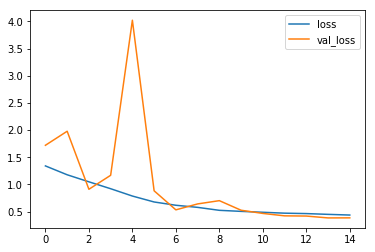

In [9]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(real_test)
y_predi = np.argmax(y_pred,axis = 1) + 1
print(np.unique(y_predi), y_predi.shape)

[1 2 3 4 5 6] (2000,)


In [17]:
answer = pd.DataFrame({"prediction":y_predi})

In [18]:
answer.to_csv('results/3-5.csv',index=False, header="label")

In [128]:
a = pd.read_csv('1-1.csv').reset_index()
b = pd.read_csv('test_vision.csv').reset_index()
c = pd.merge(a,b, on='index')
c[:50]

,index,prediction,filename
0,0,1,face_2624.png
1,1,1,face_3385.png
2,2,1,face_5015.png
3,3,1,face_6715.png
4,4,4,face_6171.png
5,5,4,face_3269.png
6,6,4,face_4942.png
7,7,5,face_1095.png
8,8,4,face_7721.png
9,9,1,face_2455.png
